# AI-Powered Public Sentiment Monitoring System 🧠📊

**Author:** Rafhiromadoni Sopandi | **Role:** AI Engineer / Data Scientist
**Model:** IndoBERT (State-of-the-Art NLP) | **Tech Stack:** PyTorch, Hugging Face, Gradio

## 📌 Executive Summary
Opini publik di media sosial bergerak sangat cepat. Metode analisis tradisional sering gagal menangkap nuansa bahasa tidak baku (*slang*).

Proyek ini membangun sistem **Analisis Sentimen Otomatis** menggunakan **IndoBERT** (BERT-based model yang dilatih khusus untuk Bahasa Indonesia). Sistem ini dirancang untuk:
1.  **Context Understanding:** Mengerti bahasa gaul, singkatan, dan sarkasme.
2.  **Real-time Monitoring:** Menyediakan dashboard interaktif untuk pemantauan krisis.

## 🔍 Case Study: Public Policy Response (PPKM)
Sebagai validasi, sistem ini diuji menggunakan dataset respons publik terhadap kebijakan pembatasan sosial.
* **Input:** Komentar publik tidak terstruktur.
* **Output:** Klasifikasi sentimen (Positif, Negatif, Netral) dengan confidence score.

##Dataset

Sumber: Twitter (dataset berlabel sentimen)

- Kolom utama:

   - Date – Tanggal tweet

  - User – Akun pengguna

  - Tweet – Teks tweet

  - Sentiment – Label sentimen (positif / negatif)

In [ ]:
# =================================================================
# LANGKAH 1: SETUP & PEMUATAN DATA
# =================================================================

# Install library yang kita butuhkan
!pip install -q wordcloud

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Nama file Anda
file_path = 'INA_TweetsPPKM_Labeled_Pure.csv'

# MEMUAT DATA DENGAN PEMISAH TAB ('\t')
print("Mencoba memuat data dengan pemisah Tab...")
df = pd.read_csv(
    file_path,
    sep="\t",
    engine="python",      # parser lebih toleran
    quoting=3,            # abaikan tanda kutip
    on_bad_lines="skip"   # skip baris rusak
)


print("✅ Data berhasil dimuat!")

print("\n--- Info Dataset Setelah Dimuat dengan Benar ---")
df.info()

print("\n--- Contoh 5 Baris Data ---")
print(df.head())

# Sekarang, mari kita lihat nama-nama kolom yang sebenarnya
print("\n--- Nama Kolom yang Ditemukan ---")
print(df.columns)

In [ ]:
df.columns = ["Date", "User", "Tweet", "Sentiment"]

print("Jumlah data:", df.shape[0])
print("\nDistribusi sentimen:")
print(df["Sentiment"].value_counts())

df.info()


In [ ]:
import pandas as pd
import re

def bersihkan_teks(teks):
    if pd.isna(teks):
        return ""
    teks = teks.lower()
    teks = re.sub(r'https?://\S+|www\.\S+', '', teks)
    teks = re.sub(r'@\w+|#\w+', '', teks)
    teks = re.sub(r'[^a-zA-Z\s]', '', teks)
    teks = re.sub(r'\s+', ' ', teks).strip()
    return teks

df["clean_tweet"] = df["Tweet"].apply(bersihkan_teks)

df[["Tweet", "clean_tweet"]].head()

In [ ]:
df["Sentiment"].value_counts().plot(kind="bar")
plt.title("Distribusi Sentimen Tweet PPKM")
plt.xlabel("Sentiment")
plt.ylabel("Jumlah")
plt.show()


In [ ]:
positive_text = " ".join(df[df["Sentiment"] == 1]["clean_tweet"])
negative_text = " ".join(df[df["Sentiment"] == 0]["clean_tweet"]) # Changed -1 to 0

wc_pos = WordCloud(width=800, height=400, background_color="white").generate(positive_text)
wc_neg = WordCloud(width=800, height=400, background_color="black").generate(negative_text)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(wc_pos)
plt.title("WordCloud Sentimen Positif")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wc_neg)
plt.title("WordCloud Sentimen Negatif")
plt.axis("off")

plt.show()

In [ ]:
label_mapping = {
    "LABEL_0": "Negatif",
    "LABEL_1": "Netral",
    "LABEL_2": "Positif"
}


In [ ]:
contoh_teks = [
    "PPKM sangat membantu menekan penyebaran covid",
    "PPKM bikin ekonomi masyarakat makin sulit",
    "ppkm anjing bikin hidup makin susah",
    "anjing keren banget kebijakan ini",
    "ppkm berlaku mulai minggu depan",
    "terima kasih ppkm hidup jadi sulit"
]


In [ ]:
df.to_csv("tweets_ppkm_clean.csv", index=False)
print("✅ Dataset bersih berhasil disimpan")


## 3. Model Architecture: Why IndoBERT?

Berbeda dengan algoritma klasik (seperti Naive Bayes) yang membaca kalimat satu arah, **IndoBERT** menggunakan mekanisme **Transformer** dan **Self-Attention**.
* **Keunggulan:** Mampu membaca seluruh kalimat sekaligus (bidirectional) untuk memahami konteks penuh.
* **Relevansi:** Sangat efektif menangani ambiguitas kata dalam Bahasa Indonesia informal.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

MODEL_NAME = "mdhugol/indonesia-bert-sentiment-classification"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer
)


In [ ]:
model.config.id2label


In [ ]:
contoh_tweet = [
    "PPKM sangat membantu menekan penyebaran covid",
    "PPKM bikin ekonomi masyarakat makin sulit"
]

sentiment_pipeline(contoh_tweet)


In [ ]:
import gradio as gr

def prediksi_sentimen(teks):
    hasil = sentiment_pipeline(teks)[0]
    sentimen = label_mapping.get(hasil["label"], "Tidak diketahui")
    return f"Sentimen: {sentimen} | Confidence: {hasil['score']:.2f}"

with gr.Blocks(title="Analisis Sentimen PPKM (IndoBERT)") as demo:

    gr.Markdown("## Analisis Sentimen PPKM (IndoBERT)")

    dropdown = gr.Dropdown(
        choices=contoh_teks,
        label="Pilih Contoh Teks",
        value=contoh_teks[0]
    )

    textbox = gr.Textbox(
        label="Atau Masukkan Teks Manual"
    )

    output = gr.Textbox(
        label="Hasil Analisis"
    )

    def gabung_input(drop, text):
        return text if text.strip() != "" else drop

    btn = gr.Button("Submit")

    btn.click(
        fn=lambda d, t: prediksi_sentimen(gabung_input(d, t)),
        inputs=[dropdown, textbox],
        outputs=output
    )

demo.launch()

## Limitasi Model
Model sentiment masih memiliki keterbatasan dalam:
- Menangani sarkasme
- Menginterpretasi kata kasar tanpa konteks
- Memahami emosi implisit

Namun, hal ini memberikan insight penting
terkait bias data Twitter dan tantangan NLP Bahasa Indonesia.


##Kesimpulan

- Proyek ini menunjukkan kemampuan saya dalam:

- Data wrangling & EDA

- Analisis teks Bahasa Indonesia

- Implementasi NLP modern (Transformer)

- Membangun aplikasi data yang siap digunakan

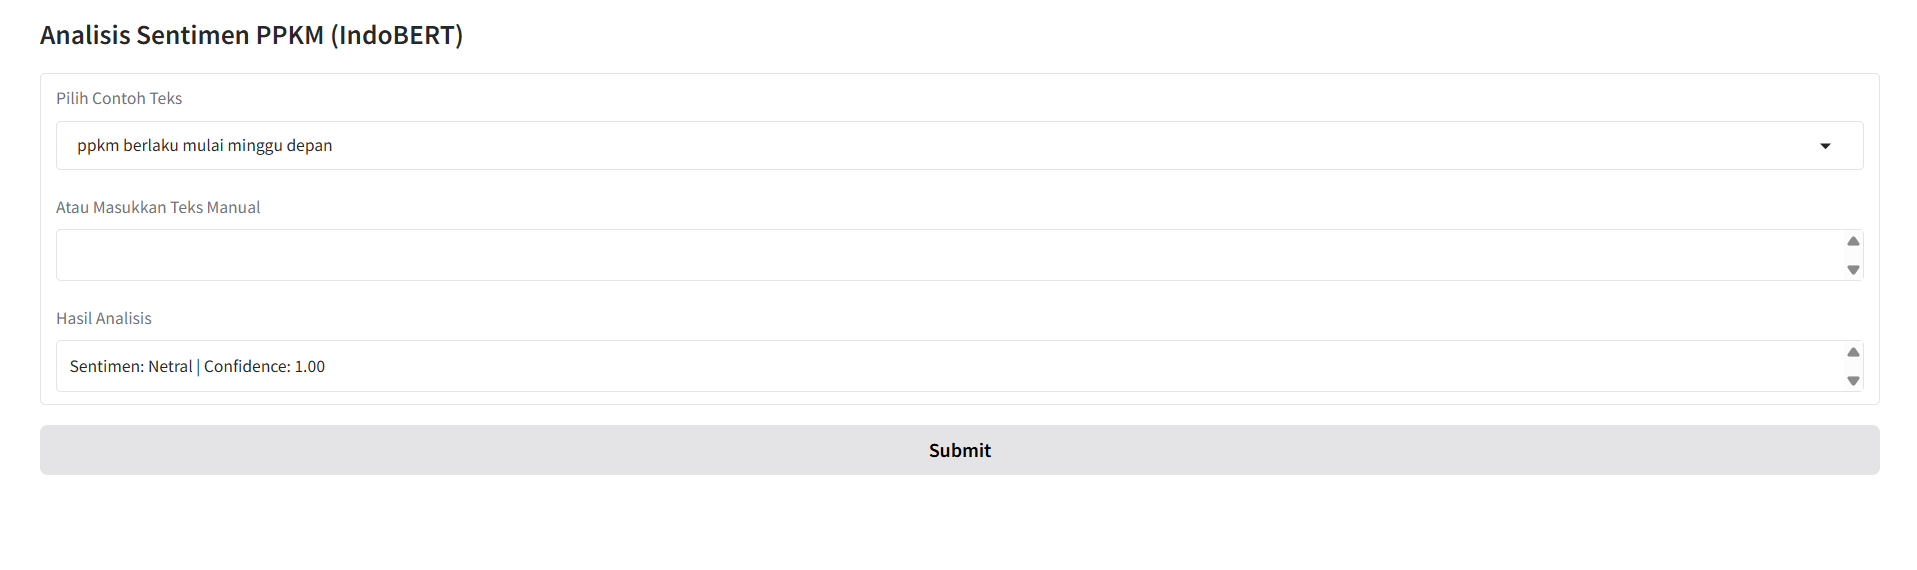